In [2]:
!pip install pyspark

!apt-get install openjdk-8-jdk-headless -qq > /dev/null

!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
!tar xf spark-3.2.1-bin-hadoop2.7.tgz

!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"

     |████████████████████████████████| 281.4 MB 34 kB/s 
     |████████████████████████████████| 198 kB 42.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=e86021adf1bf6c4776ced58d5905e79473c55a7d274c25c8a7d3c0f01f4feb12
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
spark = (SparkSession.builder.appName("project_capstone").getOrCreate())
spark

In [4]:
df_departments = spark.read.csv('departments.csv', header = True, inferSchema = True)
df_deptemp = spark.read.csv('dept_emp.csv', header = True, inferSchema = True)
df_deptmanager = spark.read.csv('dept_manager.csv', header = True, inferSchema = True)
df_employees = spark.read.csv('employees.csv', header = True, inferSchema = True)
df_salaries = spark.read.csv('salaries.csv', header = True, inferSchema = True)
df_titles = spark.read.csv('titles.csv' , header = True , inferSchema = True)

In [5]:
df = df_employees.join(df_deptemp,on = 'emp_no', how = 'left') \
        .join(df_departments, on='dept_no',how = 'left') \
        .join(df_salaries, on ='emp_no', how = 'left') \
        .join(df_titles, df_employees.emp_title_id == df_titles.title_id, 'left')

In [6]:
df.show()

+------+-------+------------+----------+----------+----------+---+----------+--------------+-----------------------+----+----------+------------------+------+--------+----------------+
|emp_no|dept_no|emp_title_id|birth_date|first_name| last_name|sex| hire_date|no_of_projects|Last_performance_rating|left| last_date|         dept_name|salary|title_id|           title|
+------+-------+------------+----------+----------+----------+---+----------+--------------+-----------------------+----+----------+------------------+------+--------+----------------+
|473302|   d002|       s0001|1953-07-25|  Hideyuki|  Zallocco|  M|1990-04-28|             2|                      A|   0|      null|           Finance| 40000|   s0001|           Staff|
|475053|   d004|       e0002|1954-11-18|     Byong| Delgrande|  F|1991-07-09|             1|                      C|   0|      null|        Production| 53422|   e0002|        Engineer|
| 57444|   d004|       e0002|1958-01-30|     Berry|      Babb|  F|1992-03-2

In [9]:
#Any null(missings) values
from pyspark.sql.functions import isnull
df_clean = df.na.drop( how = 'any' )

In [10]:
df_clean.count() == df.count()

False

In [11]:
df.printSchema()

root
 |-- emp_no: integer (nullable = true)
 |-- dept_no: string (nullable = true)
 |-- emp_title_id: string (nullable = true)
 |-- birth_date: string (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- hire_date: string (nullable = true)
 |-- no_of_projects: integer (nullable = true)
 |-- Last_performance_rating: string (nullable = true)
 |-- left: integer (nullable = true)
 |-- last_date: string (nullable = true)
 |-- dept_name: string (nullable = true)
 |-- salary: integer (nullable = true)
 |-- title_id: string (nullable = true)
 |-- title: string (nullable = true)



In [12]:
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

In [13]:
import pandas as pd

In [14]:
df1 = df.toPandas()

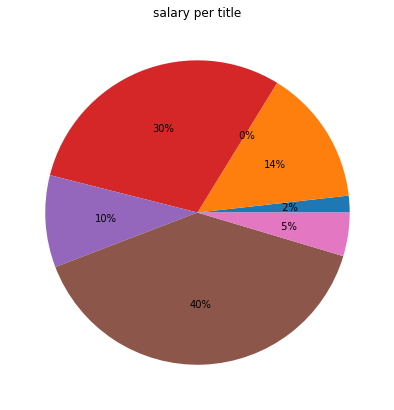

In [26]:
title_salary = df1.groupby('title')['salary'].sum()

plt.pie(title_salary,autopct="%2.0f%%" )
plt.title('salary per title')

plt.show()

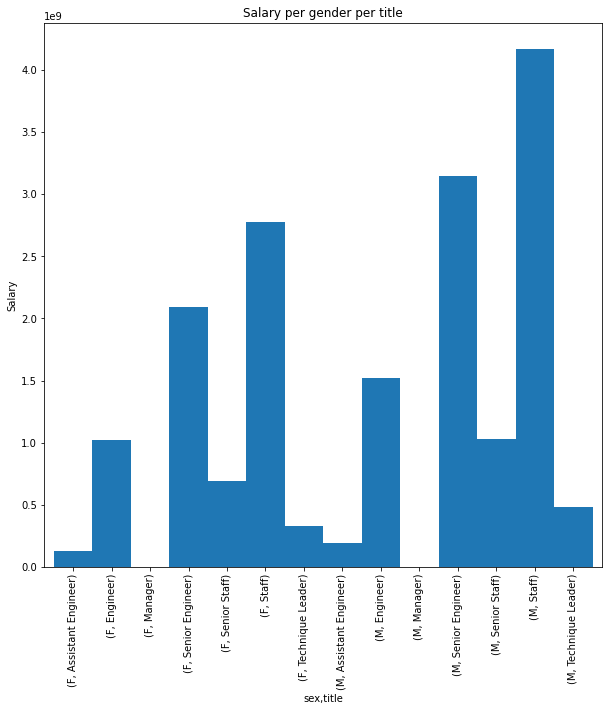

In [27]:
salary_gender_title = df1.groupby(['sex','title'])['salary'].sum()

salary_gender_title.plot(kind = 'bar',figsize=(10,10), width = 1.0)
plt.ylabel('Salary')
plt.title('Salary per gender per title')

plt.show()

In [28]:
#Columns that will be used as features and their types
continuous_features = ['salary','no_of_projects']
                    
categorical_features = ['dept_name', 'dept_no','title']

In [33]:
#Encoding all categorical features
from pyspark.ml.feature import OneHotEncoderEstimator , StringIndexer, VectorAssembler, PolynomialExpansion, VectorIndexer

In [34]:
# create object of StringIndexer class and specify input and output column
SI_dept_name = StringIndexer(inputCol='dept_name',outputCol='dept_name_Idx5')
SI_dept_no = StringIndexer(inputCol='dept_no',outputCol='dept_no_Idx5')
SI_title = StringIndexer(inputCol='title',outputCol='title_Idx5')



# transform the data
df = SI_dept_name.fit(df).transform(df)
df = SI_dept_no.fit(df).transform(df)
df = SI_title.fit(df).transform(df)



# view the transformed data
df.select('dept_name', 'dept_name_Idx5', 'dept_no', 'dept_no_Idx5', 'title','title_Idx5').show(5)

+------------------+--------------+-------+------------+---------------+----------+
|         dept_name|dept_name_Idx5|dept_no|dept_no_Idx5|          title|title_Idx5|
+------------------+--------------+-------+------------+---------------+----------+
|           Finance|           8.0|   d002|         8.0|          Staff|       0.0|
|        Production|           1.0|   d004|         1.0|       Engineer|       2.0|
|        Production|           1.0|   d004|         1.0|       Engineer|       2.0|
|   Human Resources|           7.0|   d003|         7.0|          Staff|       0.0|
|Quality Management|           6.0|   d006|         6.0|Senior Engineer|       1.0|
+------------------+--------------+-------+------------+---------------+----------+
only showing top 5 rows



In [ ]:
# create object and specify input and output column
OHE = OneHotEncoderEstimator(inputCols=['dept_name_Idx5', 'dept_no_Idx5','title_Idx5'],outputCols=['dept_name_vec5', 'dept_no_vec5','title_vec5'])

# transform the data
df = OHE.fit(df).transform(df)

# view and transform the data
df.select('dept_name', 'dept_name_Idx5', 'dept_name_vec5', 'dept_no', 'dept_no_Idx5', 'dept_no_vec5', 'title','title_Idx5','title_vec5').show(10)

In [38]:
featureCols = continuous_features + ['dept_name_vec5',   'dept_no_vec5','title_vec5'] 

In [39]:
assembler = VectorAssembler( inputCols = featureCols, outputCol = "features")

In [ ]:
train_df1 = assembler.transform( df )

+--------------------+--------------+--------------+-------+------------+-------------+------------------+----------+-------------+
|           dept_name|dept_name_Idx5|dept_name_vec5|dept_no|dept_no_Idx5| dept_no_vec5|             title|title_Idx5|   title_vec5|
+--------------------+--------------+--------------+-------+------------+-------------+------------------+----------+-------------+
|       "development"|           0.0| (8,[0],[1.0])|   d005|         0.0|(8,[0],[1.0])|   Senior Engineer|       1.0|(6,[1],[1.0])|
|             "Sales"|           2.0| (8,[2],[1.0])|   d007|         2.0|(8,[2],[1.0])|             Staff|       0.0|(6,[0],[1.0])|
|        "Production"|           1.0| (8,[1],[1.0])|   d004|         1.0|(8,[1],[1.0])|   Senior Engineer|       1.0|(6,[1],[1.0])|
|        "Production"|           1.0| (8,[1],[1.0])|   d004|         1.0|(8,[1],[1.0])|   Senior Engineer|       1.0|(6,[1],[1.0])|
|   "Human Resources"|           7.0| (8,[7],[1.0])|   d003|         7.0|(8,[7],[1.0])|             Staff|       0.0|(6,[0],[1.0])|
|       "development"|           0.0| (8,[0],[1.0])|   d005|         0.0|(8,[0],[1.0])|   Senior Engineer|       1.0|(6,[1],[1.0])|
|          "Research"|           4.0| (8,[4],[1.0])|   d008|         4.0|(8,[4],[1.0])|             Staff|       0.0|(6,[0],[1.0])|
|       "development"|           0.0| (8,[0],[1.0])|   d005|         0.0|(8,[0],[1.0])|Assistant Engineer|       5.0|(6,[5],[1.0])|
|"Quality Management"|           6.0| (8,[6],[1.0])|   d006|         6.0|(8,[6],[1.0])|   Senior Engineer|       1.0|(6,[1],[1.0])|
|"Quality Management"|           6.0| (8,[6],[1.0])|   d006|         6.0|(8,[6],[1.0])|          Engineer|       2.0|(6,[2],[1.0])|
+--------------------+--------------+--------------+-------+------------+-------------+------------------+----------+-------------+
only showing top 10 rows


In [41]:
featureCols = continuous_features + ['dept_name_vec5',   'dept_no_vec5','title_vec5'] 

In [42]:
assembler = VectorAssembler( inputCols = featureCols, outputCol = "features")

In [ ]:
train_df1 = assembler.transform( df )

In [ ]:
train_df1 = train_df1.withColumn('label', train_df1['left1'].cast('integer'))

In [ ]:
#Split the dataset
train_df, test_df = train_df1.randomSplit( [0.7, 0.3], seed = 42 )

In [ ]:
from pyspark.ml.classification import LogisticRegression

In [ ]:
#linreg = LinearRegression(maxIter=500, regParam=0.0)
linreg = LogisticRegression()

In [ ]:
lm = linreg.fit( train_df )

In [ ]:
#Make predictions on train data and evaluate
y_pred_train = lm.transform(train_df)

In [ ]:
y_pred_test = lm.transform( test_df )

In [ ]:
y_pred_test.select( 'features',  'label', 'prediction', 'left1' ).show( 5 )

+--------------------+-----+----------+-----+
|            features|label|prediction|left1|
+--------------------+-----+----------+-----+
|(24,[0,1,4,12,18]...|    0|       0.0|false|
|(24,[0,1,3,11,19]...|    0|       0.0|false|
|(24,[0,1,3,11,19]...|    0|       0.0|false|
|(24,[0,1,9,17,21]...|    0|       0.0|false|
|(24,[0,1,4,12,18]...|    0|       0.0|false|
+--------------------+-----+----------+-----+
only showing top 5 rows

In [ ]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter = 10, featuresCol='features', labelCol='label')
gbt_model = gbt.fit(train_df)

In [ ]:
predictions = gbt_model.transform(test_df)

In [43]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
accuracy

0.9013686177465785